# Detekcja twarzy
+ AUTOR: **Łukasz Staniszewski**
+ JĘZYK PROGRAMOWANIA: **Python**
+ ŚRODOWISKO TWORZENIA: **Google Colab**
+ TEMAT: **Analiza obrazu - detekcja twarzy przy użyciu kaskady Haara, HOG z SVM oraz splotowej sieci neuronowej.**

## 1. DZIAŁANIA WSTĘPNE
### 1.1 IMPORT NIEZBĘDNYCH MODUŁÓW/FUNKCJI
+ **cv2** - biblioteka zapewniająca działanie na obrazach, itp.,
+ **google.colab.patches.cv2_imshow** - funkcja gwarantująca poprawne wyświetlanie obrazów w colab,
+ **dlib** - do implementacji sieci MMOD,
+ **copy.deepcopy** - kopia głęboka obiektu,
+ **pandas** - funkcja to prezentacji tabelarycznych,
+ **timeit** - funkcja do mierzenia czasu.

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import dlib
from copy import deepcopy
import pandas as pd
import timeit

### 1.2 POBRANIE NIEZBĘDNYCH PLIKÓW
+ Koniecznym było pobranie odpowiednich plików: obraz testowy, model dla kasyfikatora haar oraz model dla klasyfikatora mmod.
+ Dodatkowo załadowano do colaba dwa obrazy, które wybrano do badań: obraz zespołu koszykarzy (id = 35) oraz obraz na giełdzie (id = 15).

In [2]:
!gdown --id 1gn7itC80mnmp9TSK8PHMEZSKMOuBVUEQ
!gdown --id 1UoFK0Jl7tY1z0ykdlvaxkFmyUR8lmLul
!gdown --id 1tb4P8NEcwTnja182AFDDnXM5ijTNQwj_

Downloading...
From: https://drive.google.com/uc?id=1gn7itC80mnmp9TSK8PHMEZSKMOuBVUEQ
To: /content/2_Demonstration_Demonstration_Or_Protest_2_1.jpg
100% 147k/147k [00:00<00:00, 51.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UoFK0Jl7tY1z0ykdlvaxkFmyUR8lmLul
To: /content/haarcascade_frontalface_default.xml
100% 930k/930k [00:00<00:00, 60.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tb4P8NEcwTnja182AFDDnXM5ijTNQwj_
To: /content/mmod_human_face_detector.dat
100% 730k/730k [00:00<00:00, 106MB/s]


## 2. OCENA METOD DLA OBRAZU TESTOWEGO
### 2.1 Załadowanie obrazu testowego
+ Na początku załadowano obraz testowy, a także jego wersje monochromatyczne oraz RGB.
+ Następnie wyświetlono obraz testowy.

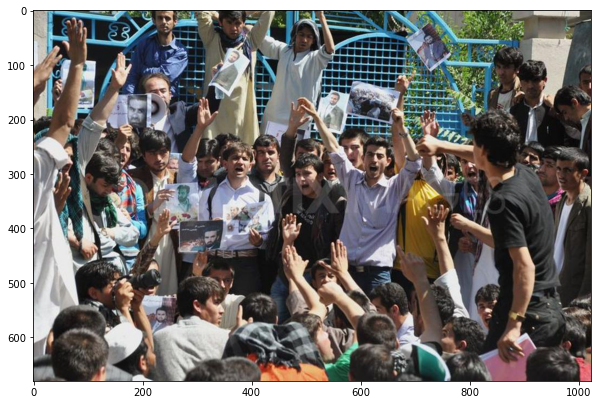

In [36]:
img_test = cv2.imread("img/2_Demonstration_Demonstration_Or_Protest_2_1.jpg")
gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
rgb_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_test)
plt.show()

### 2.3 DETEKTOR KASKADY HAARA
+ Na początku zaimplementowano funkcję wykonującą detekcję Haara (dla podanego obrazu i jego wersji w monochromie).
+ W ramach funkcji tworzony jest klasyfikator przy użyciu gotowego modelu, przeprowadzenie detekcji na obrazie w monochromie z odpowiednimi hiperparametrami (które można stroić).
+ Wszelkie wykryte obszary są wstawiane do skopiowanego obrazu oryginalnego.
+ Po wykonaniu funkcji obraz jest wyświetlany.

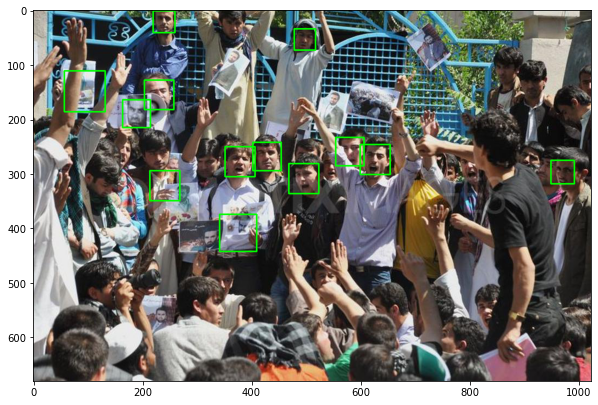

In [37]:
def detect_haar(image, image_gray):
  haar_detector = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")
  rects = haar_detector.detectMultiScale(image_gray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  img_copied = deepcopy(image)
  for (x, y, w, h) in rects:
    cv2.rectangle(img_copied, (x, y), (x + w, y + h), (0, 255, 0), 2)
  return img_copied

img_haar_test = detect_haar(img_test, gray_test)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_haar_test,cv2.COLOR_BGR2RGB))
plt.show()

### 2.3 DETEKTOR Z WEKTOREM ZORIENTOWANYCH GRADIENTÓW (HOG) I KLASYFIKATOREM SVM
+ Ze względu na fakt, że moduły dlib i opencv inaczej traktują tzw. obwiednie i niektóre z tych zwracanych przez dlib mogą wypaść poza zakres obrazu wejściowego, wprowadzona została funkcja **convert_and_trim_bb**. 
+ Gwarantuje ona konwersje koordnatów obwiedni do standardu OpenCV oraz wycina każdą obwiednię, która wypada poza zakres obrazu.
+ Dodatkowo powstała sama funkcja realizująca detekcję HOG + SVM, przyjmująca obraz wejściowy i jego wersję RGB, która pobiera model detektora twarzy, zwraca obwiednie (bounding boxes) oraz je odpowiednio przerabia z użyciem ww funkcji, a na końcu umieszcza obwiednie na kopii obrazu wejściowego.
+ Na końcu wyświetlono wynik detekcji.

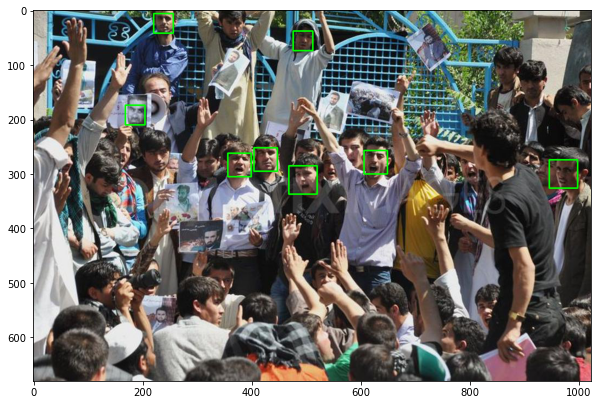

In [38]:
def convert_and_trim_bb(image, rect):
	# extract the starting and ending (x, y)-coordinates of the
	# bounding box
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()
	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
	# compute the width and height of the bounding box
	w = endX - startX
	h = endY - startY
	# return our bounding box coordinates
	return (startX, startY, w, h)

def detect_hog_svm(image, image_rgb):
  hog_svm_detector = dlib.get_frontal_face_detector()
  hog_svm_rects = hog_svm_detector(image_rgb, 1)
  hog_svm_boxes = [convert_and_trim_bb(image_rgb, r) for r in hog_svm_rects]
  img_hog_svm = deepcopy(image)
  for (x, y, w, h) in hog_svm_boxes:
    cv2.rectangle(img_hog_svm, (x, y), (x + w, y + h), (0, 255, 0), 2)
  return img_hog_svm

img_hogsvm_test=detect_hog_svm(img_test, rgb_test)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_hogsvm_test,cv2.COLOR_BGR2RGB))
plt.show()

### 2.4 DETEKTOR ZE SPOLOTOWĄ SIECIĄ NEURONOWĄ CNN
+ Zaimplementowano funkcję realizującą detektor, przyjmującą obraz wejściowy i jego wersje RGB.
+ Funkcja pobiera model detekcji, wyznacza obwiednie i konwertuje je do odp. dla opencv prostokątów (tak jak w 2.3) oraz umieszcza je na kopii obrazu wejściowego.
+ Na końcu zostaje wyświetlony wynik detektora.

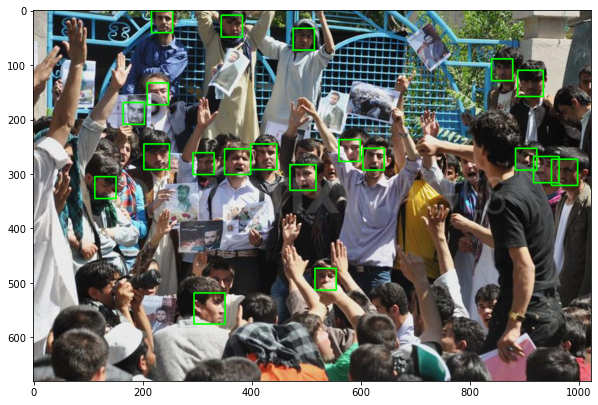

In [39]:
def detect_CNN(image, image_rgb):
  cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')
  cnn_rects = cnn_detector(image_rgb, 1)
  cnn_boxes = [convert_and_trim_bb(image, r.rect) for r in cnn_rects]
  img_cnn = deepcopy(image)
  for (x, y, w, h) in cnn_boxes:
    cv2.rectangle(img_cnn, (x, y), (x + w, y + h), (0, 255, 0), 2)
  return img_cnn
  
img_cnn_test = detect_CNN(img_test, rgb_test)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_cnn_test,cv2.COLOR_BGR2RGB))
plt.show()

### 2.5 OCENY DETEKTORÓW DLA OBRAZU TESTOWEGO
+ Na początku zestawiono wyniki kolejnych detektorów oraz zaimplementowano funkcję liczącą oceny dla nich.
+ Zastosowane oceny:
  + procent poprawnie wykrytych twarzy w obrazie,
  + procent niewykrytych twarzy w obrazie,
  + liczba obiektów niepoprawnie rozpoznanych jako twarze.
+ Na końcu wyświetlono w postaci tabelarycznej oceny dla poszczególnych detekcji.

In [40]:
N_OF_F_TEST = 47
NOTFOUND_F_TEST = [36, 39, 27]
FOUND_F_TEST = [11, 8, 20]
WRONG_F_TEST = [2, 0, 0]

def get_rating_df(NUMBER_OF_FACES_ON_IMAGE, FOUND_FACES, NOTFOUND_FACES, WRONG_FACES):
  rating_dict = dict([])
  rating_dict['FOUND FACES %'] = [100 * how_many / NUMBER_OF_FACES_ON_IMAGE for how_many in FOUND_FACES]
  rating_dict['NOT FOUND FACES %'] = [100 * how_many / NUMBER_OF_FACES_ON_IMAGE for how_many in NOTFOUND_FACES]
  rating_dict['WRONG FOUND FACES %'] = [100 * how_many / NUMBER_OF_FACES_ON_IMAGE for how_many in WRONG_FACES]
  df = pd.DataFrame(rating_dict, index=["HAAR", "HOG_SVM", "CNN"])
  print(df)

get_rating_df(N_OF_F_TEST, FOUND_F_TEST, NOTFOUND_F_TEST, WRONG_F_TEST)

         FOUND FACES %  NOT FOUND FACES %  WRONG FOUND FACES %
HAAR         23.404255          76.595745             4.255319
HOG_SVM      17.021277          82.978723             0.000000
CNN          42.553191          57.446809             0.000000


+ Jak widać, najlepiej prezentuje się detektor ze splotową siecią neuronową.
+ Minimalnie lepiej od HOG_SVM zachował się detektor HAAR, jednakże kosztem faktu wykrycia w 4% niepoprawnych twarzy na obrazie testowym. 

## 3. OCENA METOD DLA WŁASNYCH OBRAZÓW
+ Następnie koniecznym było sprawdzenie detektorów na wybranych przez siebie obrazach i ocenienie ich.
### 3.1 POBRANIE OBRAZU PROSTEGO
+ Na początku koniecznym było pobranie obrazu, sprawiającego wrażenie prostszego do detekcji, ze względu na wyraźny wygląd twarzy na nim.
+ Użyto do tego obrazu o indeksie 35 - z koszykarzami.

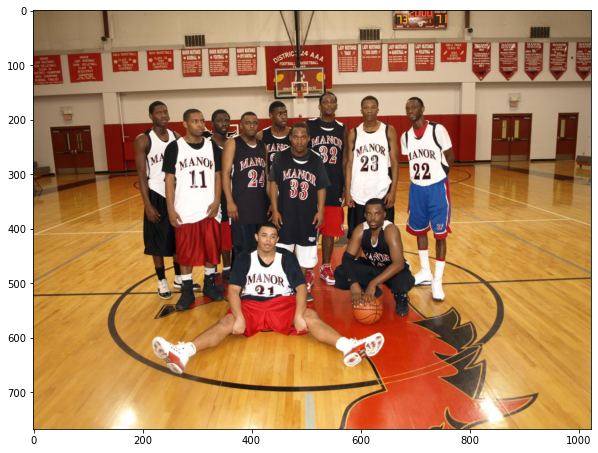

In [41]:
img_basketball = cv2.imread("img/35_Basketball_Basketball_35_180.jpg")
gray_basketball = cv2.cvtColor(img_basketball, cv2.COLOR_BGR2GRAY)
rgb_basketball = cv2.cvtColor(img_basketball, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_basketball,cv2.COLOR_BGR2RGB))
plt.show()

### 3.2 POBRANIE OBRAZU TRUDNIEJSZEGO
+ Następnie pobrano również obraz trudniejszy do detekcji ze względu na profile i pozycje twarzy na nim.
+ Wybrano w tym celu obraz o indeksie 15 - reprezentujący giełdę.

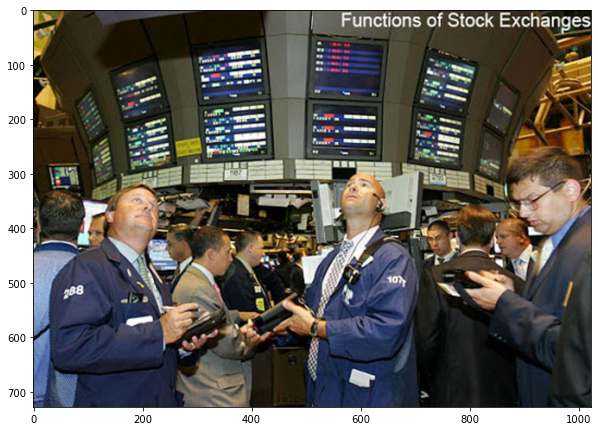

In [42]:
img_stock = cv2.imread("img/15_Stock_Market_Stock_Market_15_380.jpg")
gray_stock = cv2.cvtColor(img_stock, cv2.COLOR_BGR2GRAY)
rgb_stock = cv2.cvtColor(img_stock, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_stock,cv2.COLOR_BGR2RGB))
plt.show()

### 3.3 DETEKCJA DLA OBRAZU PROSTEGO
+ W tym punkcie przeprowadzane są detekcje dla każdego z modeli dla obrazu prostszego.
+ Następnie wyniki detekcji są wyświetlane.

BASKETBALL TEAM HAAR DETECTION


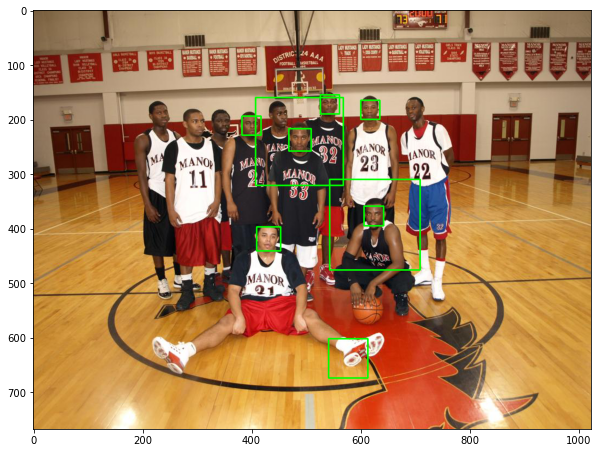

BASKETBALL HOG AND SVM DETECTION


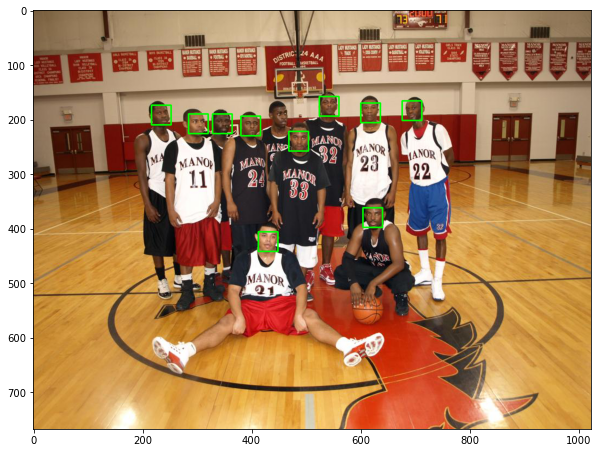

BASKETBALL CNN DETECTION


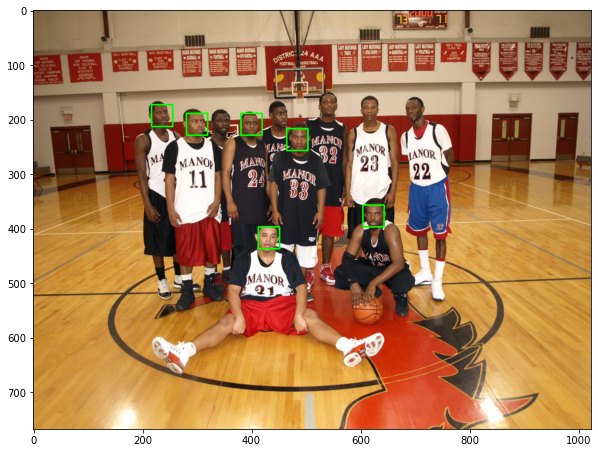

In [24]:
print("BASKETBALL TEAM HAAR DETECTION")
img_haar_basketball = detect_haar(img_basketball, gray_basketball)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_haar_basketball,cv2.COLOR_BGR2RGB))
plt.show()

print("BASKETBALL HOG AND SVM DETECTION")
img_hogsvm_basketball = detect_hog_svm(img_basketball, rgb_basketball)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_hogsvm_basketball,cv2.COLOR_BGR2RGB))
plt.show()

print("BASKETBALL CNN DETECTION")
img_cnn_basketball = detect_CNN(img_basketball, rgb_basketball)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_cnn_basketball,cv2.COLOR_BGR2RGB))
plt.show()

### 3.4 DETEKCJA DLA OBRAZU TRUDNIEJSZEGO
+ W tym punkcie przeprowadzane są detekcje dla każdego z modeli dla obrazu trudniejszego.
+ Następnie wyniki detekcji są wyświetlane.

STOCK HAAR DETECTION


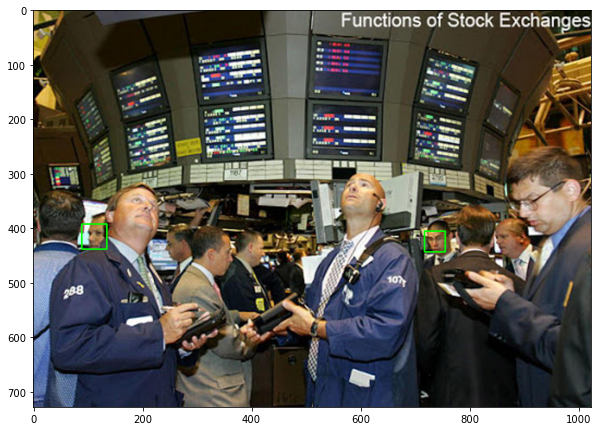

STOCK HOG AND SVM DETECTION


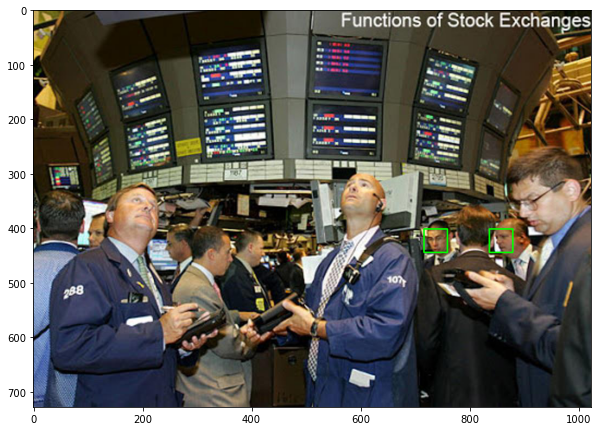

STOCK CNN DETECTION


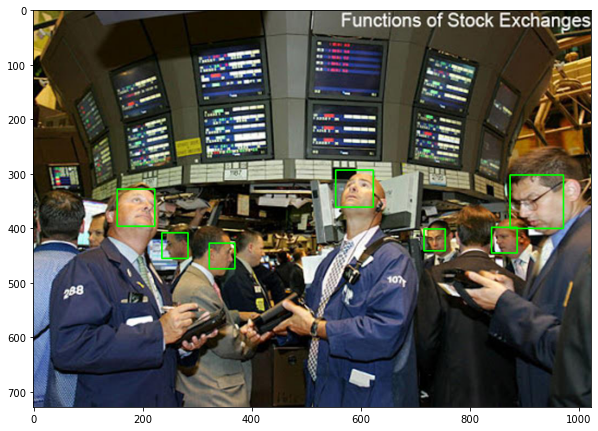

In [27]:
print("STOCK HAAR DETECTION")
img_haar_stock = detect_haar(img_stock, gray_stock)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_haar_stock,cv2.COLOR_BGR2RGB))
plt.show()

print("STOCK HOG AND SVM DETECTION")
img_hogsvm_stock = detect_hog_svm(img_stock, rgb_stock)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_hogsvm_stock,cv2.COLOR_BGR2RGB))
plt.show()

print("STOCK CNN DETECTION")
img_cnn_stock = detect_CNN(img_stock, rgb_stock)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_cnn_stock,cv2.COLOR_BGR2RGB))
plt.show()

### 3.5 OCENA DETEKCJI
+ W tym punkcie zostały ocenione wszystkie detektory dla obu obrazów.
+ Na początku zliczono odpowiednie parametry ocen, które są identyczne z tymi z punktu 2.5.

In [25]:
N_OF_F_BASKETBALL = 11
NOTFOUND_F_BASKETBALL = [5, 1, 5]
FOUND_F_BASKETBALL = [6, 10, 6]
WRONG_F_BASKETBALL = [3, 0, 0]

N_OF_F_STOCK = 11
NOTFOUND_F_STOCK = [9, 10, 4]
FOUND_F_STOCK = [2, 1, 7]
WRONG_F_STOCK = [0, 0, 0]

+ Następnie wywołano funkcje wyliczające oceny i wyświetlające je w postaci tabelarycznej.

In [26]:
print("MARKS FOR BASKETBALL - SIMPLIER - PICTURE")
get_rating_df(N_OF_F_BASKETBALL, FOUND_F_BASKETBALL, NOTFOUND_F_BASKETBALL, WRONG_F_BASKETBALL)
print("MARKS FOR STOCK - MORE DIFFICULT - PICTURE")
get_rating_df(N_OF_F_STOCK, FOUND_F_STOCK, NOTFOUND_F_STOCK, WRONG_F_STOCK)

MARKS FOR BASKETBALL - SIMPLIER - PICTURE
         FOUND FACES %  NOT FOUND FACES %  WRONG FOUND FACES %
HAAR         54.545455          45.454545            27.272727
HOG_SVM      90.909091           9.090909             0.000000
CNN          54.545455          45.454545             0.000000
MARKS FOR STOCK - MORE DIFFICULT - PICTURE
         FOUND FACES %  NOT FOUND FACES %  WRONG FOUND FACES %
HAAR         18.181818          81.818182                  0.0
HOG_SVM       9.090909          90.909091                  0.0
CNN          63.636364          36.363636                  0.0


+ Można tu zauważyć, że dla obrazu prostego całkiem nieźle poradził sobie algorytm HOG Z klasyfikatorem SVM. Pozostałe algorytmy zadziałały w połowie poprawnie, jednak w przypadku algorytmu HAAR było nieco gorzej - wykrył on również niepoprawnie niektóre twarze.
+ Jeśli chodzi o obraz trudniejszy, najlepiej poradził sobie algorytm ze splotową siecią neuronową. Pozostałe zadziałały bardzo źle - algorytmy miały skuteczność na poziomie 10%/20%.

## 4. MODYFIKACJE ALGORYTMU
+ W tym punkcie postanowiono lekko zmodyfikować algorytm dla detektora HAAR - ma on w swojej budowie hiperparametry, które, odpowiednio dostrojne, mogą zagwarantować lepszą detekcję.
+ Tak więc zastosowano strojenie trzech hiperparametrów:
  + scaleFactor,
  + minNeighbors,
  + minSize.

### 4.1 DLA OBRAZU PROSTEGO
+ Tu najlepiej wypadły parametry:
  + scaleFactor = 1.005,
  + minNeighbors = 158,
  + minSize = (10, 10).
+ Wyeliminowało to 3 błędy w detekcji.

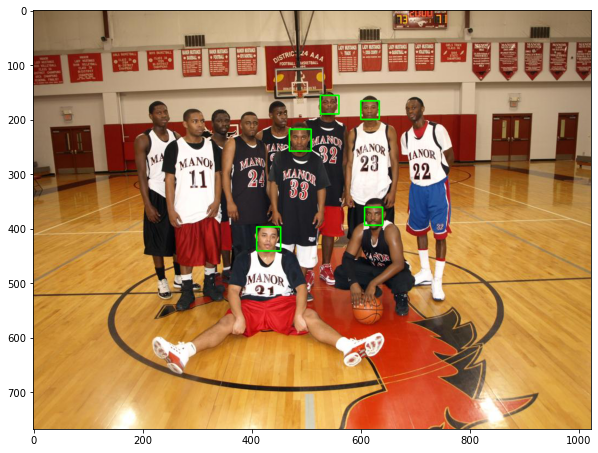

In [28]:
def detect_haar(image, image_gray):
  haar_detector = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")
  rects = haar_detector.detectMultiScale(image_gray, scaleFactor=1.005, minNeighbors=158, minSize=(10, 10), flags=cv2.CASCADE_SCALE_IMAGE)
  img_copied = deepcopy(image)
  for (x, y, w, h) in rects:
    cv2.rectangle(img_copied, (x, y), (x + w, y + h), (0, 255, 0), 2)
  return img_copied

img_haar_basketball_mod = detect_haar(img_basketball, gray_basketball)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_haar_basketball_mod,cv2.COLOR_BGR2RGB))
plt.show()

### 4.2 DLA OBRAZU TRUDNIEJSZEGO
+ Tu najlepiej wypadły parametry:
  + scaleFactor = 1.08,
  + minNeighbors = 2,
  + minSize = (30, 30).
+ Pozwoliło to na wykrycie jednej dodatkowej twarzy.

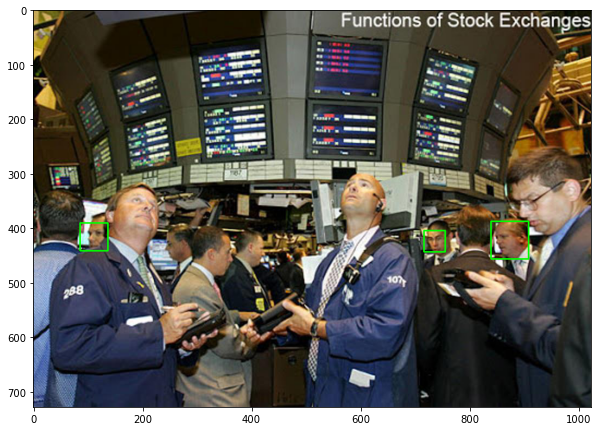

In [29]:
def detect_haar(image, image_gray):
  haar_detector = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")
  rects = haar_detector.detectMultiScale(image_gray, scaleFactor=1.08, minNeighbors=2, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  img_copied = deepcopy(image)
  for (x, y, w, h) in rects:
    cv2.rectangle(img_copied, (x, y), (x + w, y + h), (0, 255, 0), 2)
  return img_copied

img_haar_stock_mod = detect_haar(img_stock, gray_stock)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_haar_stock_mod,cv2.COLOR_BGR2RGB))
plt.show()

## 5. CZASY ALGORYTMÓW DETEKUJĄCYCH TWARZE NA OBRAZIE
+ W ostatnim etapie koniecznym było zmierzenie jak działają pod względem czasowym dane detektory.
+ W tym celu zastosowano funkcję biblioteki **timeit** do wykonania pomiarów.


In [30]:
time_haar = timeit.timeit(lambda:  detect_haar(img_basketball, gray_basketball), number=1)
time_hog_svm = timeit.timeit(lambda:  detect_hog_svm(img_basketball, rgb_basketball), number=1)
time_cnn = timeit.timeit(lambda:  detect_CNN(img_basketball, rgb_basketball), number=1)

+ Na końcu wyświetlono zmierzone czasy w postaci tabelarycznej.

In [31]:
times_dict = dict([])
times_dict['time(s)'] = [time_haar, time_hog_svm, time_cnn]
times_df = pd.DataFrame(times_dict, index=['HAAR', 'HOG AND SVM', 'CNN'])
times_df

time(s)
HAAR          0.210024
HOG AND SVM   0.934552
CNN          77.661243

+ Jak widać, najszybciej zadziałał algorytm ze splotową siecią neuronową, a najwolniej histogram zorientowanych gradientów HOG z klasyfikatorem SVM.
+ Trzeba jednak zwrócić uwagę, że w przypadku obrazu koszykarzy (tego, który wybrano do liczenia czasów) to właśnie detektor HOG z SVM zadziałał najlepiej.